##### Copyright 2023 Melchor Lafuente Duque

# IMAGE TO AUDIO - IDCT

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import scipy.io.wavfile as wavfile
import scipy.fftpack as sp
import scipy.signal as s
import cupy as cp
from PIL import Image
import imageio.v2 as imageio
import os

## Functions to read and write wav, txt and npy files

In [2]:
def read_wav(file_name, dir_name_input = "INPUT"):
    file_location = join(dir_name_input, file_name + ".wav")
    sample_rate, signal = wavfile.read(file_location)
    
    # If the signal is stereo, we transform it to mono:
    if signal.ndim > 1:
        left_channel = signal[:, 0]
        right_channel = signal[:, 1]
        signal = np.mean([left_channel, right_channel], axis=0)   
        
    return sample_rate, signal

def write_wav(file_name, sr, signal, output_dir_name = "OUTPUT"):
    current_dir = os.getcwd()
    output_path = os.path.join(current_dir, output_dir_name)
    file_name_output = os.path.join(output_path, file_name + ".wav")
    wavfile.write(file_name_output, sr, signal.astype('int16'))

In [3]:
def write_txt(output_dir_name, signal_name, filename, data, data_type = '%d'):
    current_dir = os.getcwd()
    output_path = os.path.join(current_dir, output_dir_name)
    filename_output = os.path.join(output_path, signal_name + "_" + filename + ".txt")
    np.savetxt(filename_output, [data], fmt = data_type)

In [4]:
def write_npy(output_dir_name, signal_name, filename, data):
    current_dir = os.getcwd()
    output_path = os.path.join(current_dir, output_dir_name)
    filename_output = os.path.join(output_path, signal_name + "_" + filename + ".npy")
    np.save(filename_output, data)

## SETUP

We define the GPU device that we are going to use, in my case, I have three devices that I could use. So I will use one that is not being used by the previous process, the number one for example: 

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1" #0,1,2,3

We define a function to plot the signals:

In [6]:
def plot_signal(sr, signal, file_name, file_suffix = "wav"):
    
    # Compute time axis in seconds
    time = np.arange(len(signal)) / float(sr)
    duration = time.max()

    # Plot audio signal
    fig, ax = plt.subplots()

    ax.plot(time, signal)
    
    # Add a title and axis labels
    file_location = join(file_name + "." + file_suffix)
    
    ax.set_title(file_location)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude (A)")

    plt.show()

In [7]:
def plot_freq_array(freq_array):
    print("The image below has a dimension of: ", freq_array.T.shape)

    # Display the frequency domain image
    fig, ax = plt.subplots(figsize=(18, 3))
    ax.imshow(freq_array.T, aspect='auto', origin='lower')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Time (segment index)')
    fig.show()

## Functions to read images and their range of frequencies

In [8]:
def read_max_min(dir_name_input, signal_name = "ORIGINAL", max_filename = "max", min_filename = "min"):
    
    max_filename = signal_name + "_" + max_filename + ".txt"
    min_filename = signal_name + "_" + min_filename + ".txt"
    
    file_location_max = join(dir_name_input, max_filename)
    file_location_min = join(dir_name_input, min_filename)
    
    freq_max = np.loadtxt(file_location_max, dtype=np.float64)
    freq_min = np.loadtxt(file_location_min, dtype=np.float64)
    return freq_max, freq_min

In [9]:
def read_image(dir_name_input, signal_name = "ORIGINAL", img_filename = "image", img_suffix = "png"):
    img_filename = signal_name + "_" + img_filename + "." + img_suffix
    
    file_location_img = join(dir_name_input, img_filename)
    
    return np.asarray(imageio.imread(file_location_img)).astype("float64")

# IMAGE TO AUDIO:

## Read Image

The image below has a dimension of:  (662, 21837)


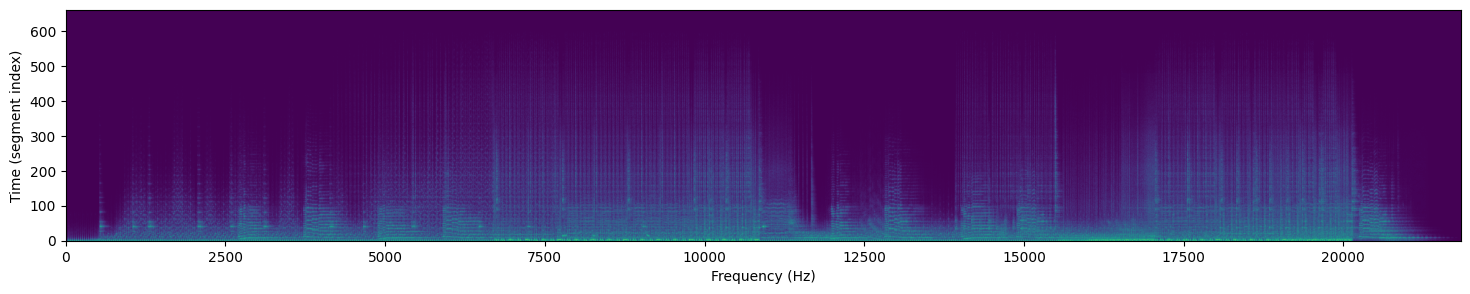

In [10]:
# read the image as a numpy array
img_float64 = read_image(dir_name_input = "OUTPUT_1", signal_name = "ORIGINAL")

# normalize the array to the range [0,1]
img_float64 = (img_float64) / 255.0

freq_max, freq_min = read_max_min(dir_name_input = "OUTPUT_1", signal_name = "ORIGINAL")

# return the original values
img_reconstructed = ((freq_max - freq_min) * img_float64) + freq_min

# Display the frequency domain image
plot_freq_array(img_reconstructed.T)

## Freq ARRAY TO AUDIO

In [11]:
def obtain_dct_segments(freq_array, mat_signs):
    return (np.exp(freq_array) - 1) * mat_signs

In [12]:
def write_reconstructed_signal(freq_array, mat_signs, segment_length, sample_rate, n_samples, output_dir_name = "OUTPUT", file_name = "RECONSTRUCTED_FROM_ORIGINAL_IMAGE"):
    # Inverse the process to reconstruct the original signal
    reconstructed_signal = np.zeros(n_samples)

    dct_segments = obtain_dct_segments(freq_array, mat_signs)

    for i, segment in enumerate(dct_segments):
        segment_signal = sp.idct(segment, type=2, norm='ortho')
        reconstructed_signal[i * segment_length : i * segment_length + segment_length] += segment_signal

    # Normalize the reconstructed signal to [-1, 1] range
    reconstructed_signal = reconstructed_signal / np.max(np.abs(reconstructed_signal))

    # Scale the signal back to the original 16-bit range
    reconstructed_signal = np.int16(reconstructed_signal * (2**15))
    
    # Write the reconstructed signal to a new .wav file
    write_wav(file_name, sr = sample_rate, signal = reconstructed_signal, output_dir_name = output_dir_name)

# Audio Reconstruction from image .png

In [13]:
mat_signs = np.load(join("OUTPUT_1", "ORIGINAL_mat_signs.npy"))
sample_rate = np.loadtxt(join("OUTPUT_1", "ORIGINAL_sample_rate.txt"), dtype=int)
n_samples = np.loadtxt(join("OUTPUT_1", "ORIGINAL_n_samples.txt"), dtype=int)
segment_length = np.loadtxt(join("OUTPUT_1", "ORIGINAL_segment_length.txt"), dtype=int)

In [14]:
write_reconstructed_signal(img_reconstructed.T, mat_signs, segment_length, sample_rate, n_samples, file_name = "RECONSTRUCTED_FROM_ORIGINAL_IMAGE", output_dir_name = "OUTPUT_2")

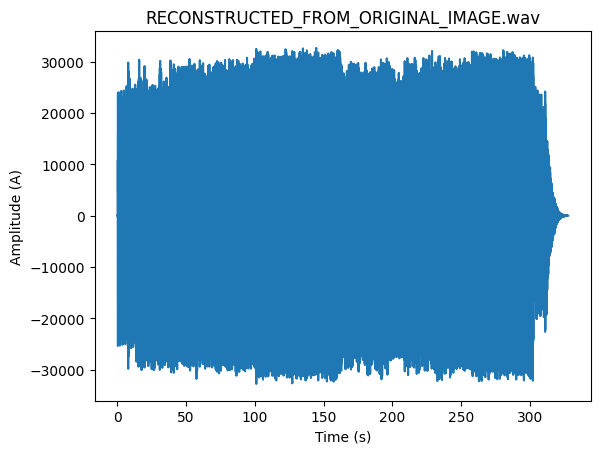

In [15]:
sample_rate_2, reconstructed_signal = read_wav(file_name = "RECONSTRUCTED_FROM_ORIGINAL_IMAGE", dir_name_input = "OUTPUT_2")
plot_signal(sample_rate_2, reconstructed_signal, file_name = "RECONSTRUCTED_FROM_ORIGINAL_IMAGE", file_suffix = "wav")